**Step 1: Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import math
import random
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix


**Step 2: Load and Preprocess Data**

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/unified-text/Unified_Text.csv")
df.fillna('', inplace=True)

# Basic tokenization
def tokenize(text):
    return text.lower().split()

df["tokens"] = df["log_text"].apply(tokenize)


/tmp/ipykernel_35/426792312.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


**Step 3: Compute Stable IDF**

In [4]:
def compute_idf(documents):
    N = len(documents)
    idf = {}
    all_words = set(word for doc in documents for word in doc)

    for word in all_words:
        df_count = sum(1 for doc in documents if word in doc)
        idf[word] = math.log((1 + N) / (1 + df_count)) + 1  # Smooth +1
    return idf

idf = compute_idf(df["tokens"])


**Step 4: Compute TF and TF-IDF**

In [5]:
def compute_tf(tokens):
    tf = {}
    word_counts = Counter(tokens)
    total_terms = len(tokens)
    for word, count in word_counts.items():
        tf[word] = count / total_terms
    return tf

df["tf"] = df["tokens"].apply(compute_tf)

def compute_tfidf(tf, idf):
    tfidf = {}
    for word, tf_val in tf.items():
        tfidf[word] = tf_val * idf.get(word, 0.0)
    return tfidf

df["tfidf"] = df["tf"].apply(lambda tf: compute_tfidf(tf, idf))


**Step 5: Convert TF-IDF to Sparse Matrix**

In [6]:
vectorizer = DictVectorizer(sparse=True)
tfidf_sparse_matrix = vectorizer.fit_transform(df["tfidf"])


**Use Semantically-Rich Input (Not Raw TF-IDF)
Raw TF-IDF (especially sparse) doesn't encode meaning.
Fix: Use TruncatedSVD (LSA) to reduce TF-IDF to dense semantic features.**

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_dense = svd.fit_transform(tfidf_sparse_matrix)


**Add Log Structural Features**

In [8]:
df["log_length"] = df["log_text"].apply(len)
df["num_digits"] = df["log_text"].apply(lambda x: sum(c.isdigit() for c in x))
df["num_words"] = df["log_text"].apply(lambda x: len(x.split()))


In [9]:
from sklearn.preprocessing import StandardScaler
meta = df[["log_length", "num_digits", "num_words"]]
meta_scaled = StandardScaler().fit_transform(meta)

X = np.hstack([tfidf_dense, meta_scaled])


**Step 6: Optional — Convert Sparse Matrix to Dense (Top N Features Only**

In [10]:
# # Optional: if using your own Isolation Forest (which expects DataFrame), convert a portion to dense
# top_n_features = 5000  # You can increase/decrease based on memory
# tfidf_matrix = pd.DataFrame(tfidf_sparse_matrix.toarray()[:, :top_n_features])


**Step 7: Custom Isolation Forest (Improved with Empty-Split Check)**

In [11]:
import random
import numpy as np
import pandas as pd
import math

class IsolationTree:
    def __init__(self, depth=0, max_depth=10, n_sample=None):
        self.depth = depth
        self.max_depth = max_depth
        self.n_sample = n_sample  # Track how many samples used to build this tree
        self.left = None
        self.right = None
        self.split_attr = None
        self.split_val = None

    def fit(self, X):
        if self.depth >= self.max_depth or len(X) <= 5:
            return

        self.split_attr = random.choice(X.columns)
        col = X[self.split_attr]

        min_val, max_val = col.min(), col.max()
        if min_val == max_val:
            return

        self.split_val = random.uniform(min_val, max_val)

        left_mask = col < self.split_val
        right_mask = col >= self.split_val

        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return

        self.left = IsolationTree(depth=self.depth + 1, max_depth=self.max_depth, n_sample=self.n_sample)
        self.left.fit(X[left_mask])

        self.right = IsolationTree(depth=self.depth + 1, max_depth=self.max_depth, n_sample=self.n_sample)
        self.right.fit(X[right_mask])

    def path_length(self, x):
        if self.left is None or self.right is None:
            return self.depth
        if x[self.split_attr] < self.split_val:
            return self.left.path_length(x)
        else:
            return self.right.path_length(x)

class IsolationForestScratch:
    def __init__(self, n_trees=100, max_depth=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X):
        self.X = X.reset_index(drop=True)
        self.trees = []
        self.sample_sizes = []
        for _ in range(self.n_trees):
            sample = self.X.sample(frac=1.0, replace=True).reset_index(drop=True)
            tree = IsolationTree(depth=0, max_depth=self.max_depth, n_sample=len(sample))
            tree.fit(sample)
            self.trees.append(tree)

    def c(self, n):
        # Expected path length for n samples
        if n <= 1:
            return 1
        return 2 * (np.log(n - 1) + 0.5772) - (2 * (n - 1) / n)

    def anomaly_score(self, x):
        scores = []
        for tree in self.trees:
            h = tree.path_length(x)
            c_n = self.c(tree.n_sample)
            scores.append(2 ** (-h / c_n))
        return np.mean(scores)

    def predict(self, X, anomaly_percentile):
        scores = X.apply(lambda x: self.anomaly_score(x), axis=1)
        threshold = np.percentile(scores, anomaly_percentile)
        labels = scores.apply(lambda s: -1 if s >= threshold else 1)
        return labels, scores


**Find the Best Anomaly Threshold Using Elbow Method**

In [12]:
iso_forest = IsolationForestScratch(n_trees=100, max_depth=10)
iso_forest.fit(pd.DataFrame(X))

df['anomaly'], df['anomaly_score'] = iso_forest.predict(pd.DataFrame(X), anomaly_percentile=90)

print("Normal:", (df['anomaly'] == 1).sum())
print("Anomalies:", (df['anomaly'] == -1).sum())


Normal: 48567
Anomalies: 5406


**Step 8: Train Isolation Forest and Label Data**

In [13]:
df.head()

,Unnamed: 0,log_type,source_ip,component,level,status,event_id,content,Year,Month,...,Minute,log_text,tokens,tf,tfidf,log_length,num_digits,num_words,anomaly,anomaly_score
0,0,Access,1.202.218.8,,,404,,GET /robots.txt HTTP/1.0,2012.0,6.0,...,5.0,"Log Type: Access, Source IP: 1.202.218.8, Leve...","[log, type:, access,, source, ip:, 1.202.218.8...","{'log': 0.05, 'type:': 0.05, 'access,': 0.05, ...","{'log': 0.05, 'type:': 0.05, 'access,': 0.2121...",146,25,20,1,0.718272
1,1,Access,208.115.113.91,,,200,,GET /logs/?C=M;O=D HTTP/1.1,2012.0,6.0,...,20.0,"Log Type: Access, Source IP: 208.115.113.91, L...","[log, type:, access,, source, ip:, 208.115.113...","{'log': 0.05, 'type:': 0.05, 'access,': 0.05, ...","{'log': 0.05, 'type:': 0.05, 'access,': 0.2121...",152,28,20,1,0.718272
2,2,Access,123.125.71.20,,,200,,GET / HTTP/1.1,2012.0,6.0,...,30.0,"Log Type: Access, Source IP: 123.125.71.20, Le...","[log, type:, access,, source, ip:, 123.125.71....","{'log': 0.05, 'type:': 0.05, 'access,': 0.05, ...","{'log': 0.05, 'type:': 0.05, 'access,': 0.2121...",138,27,20,1,0.718272
3,3,Access,220.181.108.101,,,200,,GET / HTTP/1.1,2012.0,6.0,...,31.0,"Log Type: Access, Source IP: 220.181.108.101, ...","[log, type:, access,, source, ip:, 220.181.108...","{'log': 0.05, 'type:': 0.05, 'access,': 0.05, ...","{'log': 0.05, 'type:': 0.05, 'access,': 0.2121...",140,29,20,1,0.719849
4,4,Access,123.125.68.79,,,200,,GET / HTTP/1.1,2012.0,6.0,...,53.0,"Log Type: Access, Source IP: 123.125.68.79, Le...","[log, type:, access,, source, ip:, 123.125.68....","{'log': 0.05, 'type:': 0.05, 'access,': 0.05, ...","{'log': 0.05, 'type:': 0.05, 'access,': 0.2121...",138,27,20,1,0.718272


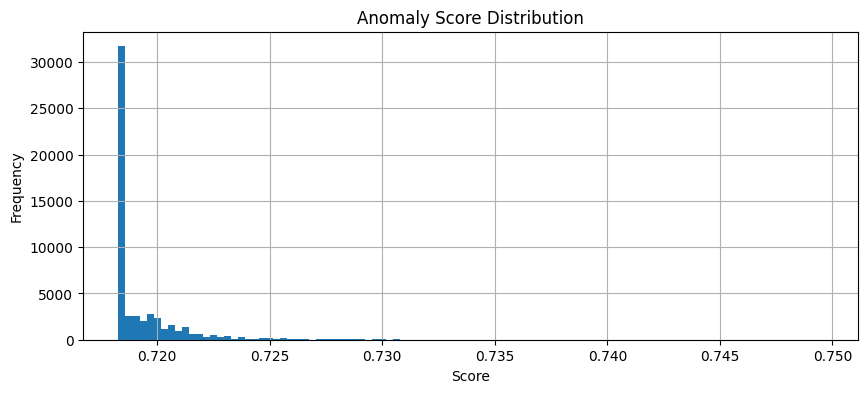

In [14]:
import matplotlib.pyplot as plt

df['anomaly_score'].hist(bins=100, figsize=(10, 4))
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


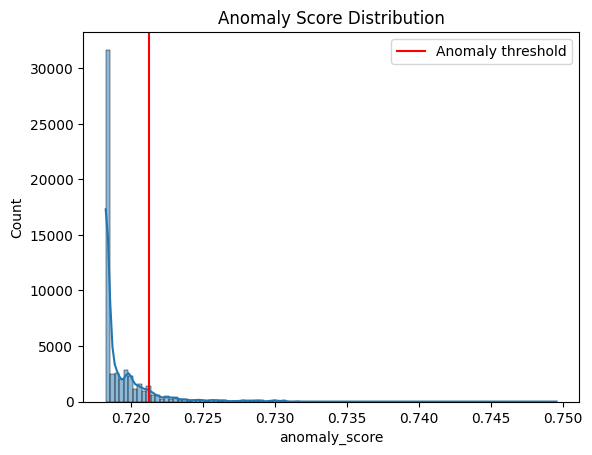

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["anomaly_score"], bins=100, kde=True)
plt.axvline(df[df["anomaly"] == -1]["anomaly_score"].min(), color='red', label="Anomaly threshold")
plt.legend()
plt.title("Anomaly Score Distribution")
plt.show()


In [16]:
from sklearn.ensemble import IsolationForest

sklearn_if = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.10)
sklearn_if.fit(X)
df["sklearn_anomaly"] = sklearn_if.predict(X)

print("Custom IF anomalies:", (df["anomaly"] == -1).sum())
print("Sklearn IF anomalies:", (df["sklearn_anomaly"] == -1).sum())


Custom IF anomalies: 5406
Sklearn IF anomalies: 5398


In [17]:
df.to_csv("Stage4_Isolated_data.csv")

In [18]:
df['response'] = df['anomaly'].map({1: 'normal', -1: 'anomalous'})

In [19]:
import json

with open('llama2_finetune_data.jsonl', 'w') as f:
    for _, row in df.iterrows():
        json.dump({
            "instruction": "Analyze the following log and classify it as normal or anomalous.",
            "input": row["log_text"],
            "output": row["response"]
        }, f)
        f.write('\n')
